In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

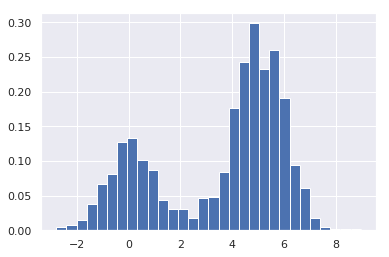

In [4]:
hist = plt.hist(x, bins=30, density=True)

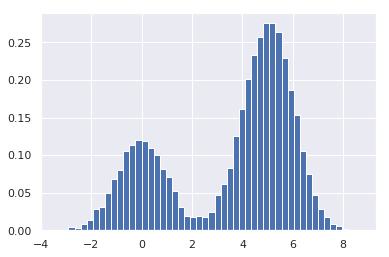

In [8]:
hist2 = plt.hist(make_data(20000, rseed=10), bins=50, density=True)

# KDE to estimate the characteristics of data

(-0.02, 0.22)

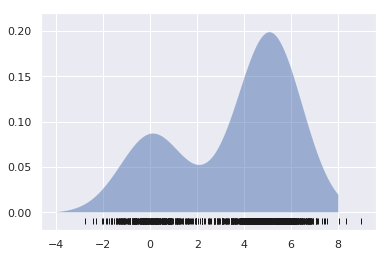

In [10]:
from sklearn.neighbors import KernelDensity
x_d = np.linspace(-4, 8, 1000)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)